# Tutorial

In [1]:
## enable auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

## 1. Preprocessed 데이터 로드

In [3]:
RAW_PATH = './data'            ## path to raw data
NP_PATH = './preprocessed'     ## path to preprocessed data
FRAME_LEN = 1024               ## length of one data frame
FRAME_INTV = 512               ## interval between data frames

In [4]:
if not os.path.exists(NP_PATH):
    os.mkdir(NP_PATH)

In [5]:
from src.utils.data_utils import get_preprocessed_data

## load preprocessed data
DATA, train_idx, test_idx, trainY, testY, train_diameter, test_diameter, train_rpm, test_rpm = get_preprocessed_data(RAW_PATH, NP_PATH, FRAME_LEN, FRAME_INTV)

print('DATA :\t\t', DATA.shape)
print('train_idx :\t', train_idx.shape)
print('test_idx :\t', test_idx.shape)
print('trainY :\t', trainY.shape)
print('testY :\t\t', testY.shape)
print('train_diameter :', train_diameter.shape)
print('test_diameter :\t', test_diameter.shape)
print('train_rpm :\t', train_rpm.shape)
print('test_rpm :\t', test_rpm.shape)

DATA :		 (9012305, 1)
train_idx :	 (13966,)
test_idx :	 (3539,)
trainY :	 (13966,)
testY :		 (3539,)
train_diameter : (13966,)
test_diameter :	 (3539,)
train_rpm :	 (13966,)
test_rpm :	 (3539,)


### 데이터 설명
- **DATA** :  하나로 합쳐진 베어링 데이터의 총 구간 *(total_length, 1)*
    
- **train_idx / test_idx** : train/test 데이터셋의 각 프레임 시작 위치 *(dataset_size,)*

- **trainY / testY** : train/test 데이터셋의 True Label *(dataset_size,)*
    
- **train_diameter / test_diameter** : train/test 데이터셋의 파괴 직경 *(dataset_size,)*


<img src="resources/data.png" width="500">


## 2. 데이터 이해하기

***<DataAnalysis.ipynb>에서 직접 다양하게 실행해볼 수 있습니다.***

*전체 데이터 구간 확인*

<IPython.core.display.Javascript object>


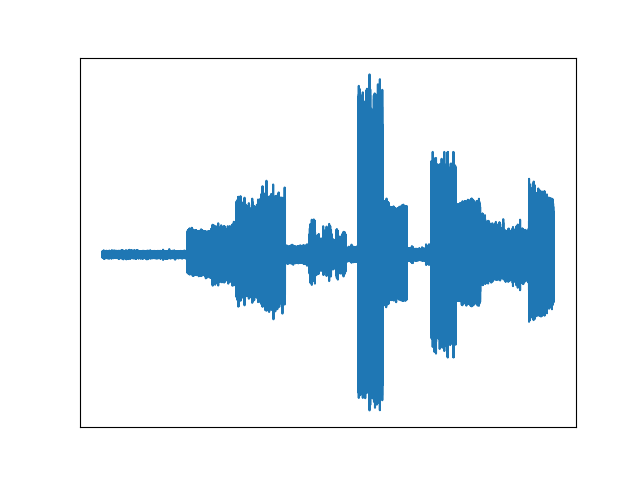

In [6]:
%matplotlib notebook

## remove ticks
plt.xticks([])
plt.yticks([])

## plot DATA
plt.plot(DATA)
plt.show()

*train 데이터셋의 I번째 데이터(I번째 프레임) 확인*

<IPython.core.display.Javascript object>


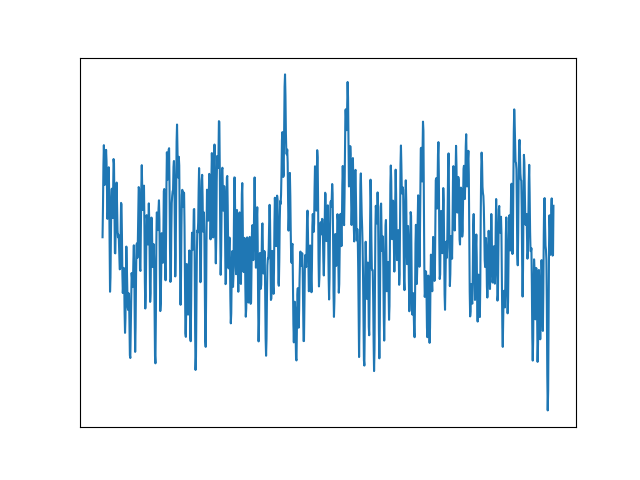

In [7]:
%matplotlib notebook

## define I
I = 0

## remove ticks
plt.xticks([])
plt.yticks([])

## plot I'th train frame
plt.plot(DATA[train_idx[I]:train_idx[I]+FRAME_LEN])
plt.show()

*test 데이터셋의 I번째 데이터(I번째 프레임) 확인*

<IPython.core.display.Javascript object>


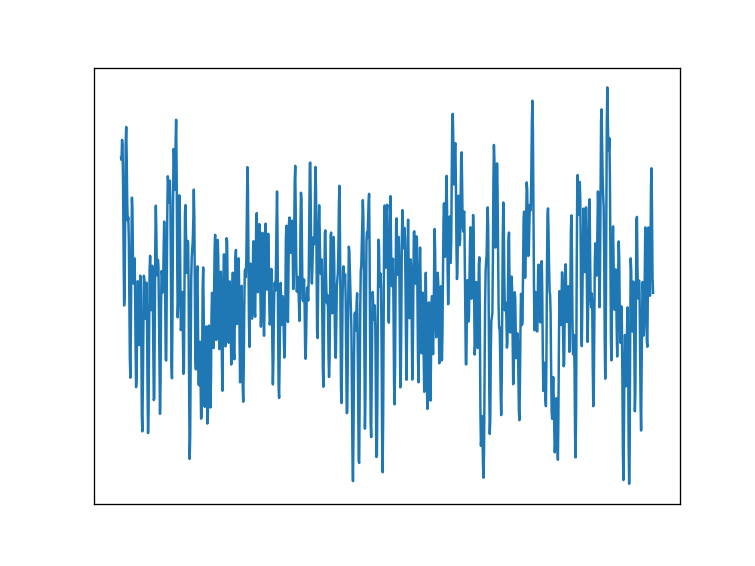

In [8]:
%matplotlib notebook

## define I
I = 0

## remove ticks
plt.xticks([])
plt.yticks([])

## plot I'th test frame
plt.plot(DATA[test_idx[I]:test_idx[I]+FRAME_LEN])
plt.show()

*각 Label의 I번째 데이터(I번째 프레임) 확인*

<IPython.core.display.Javascript object>


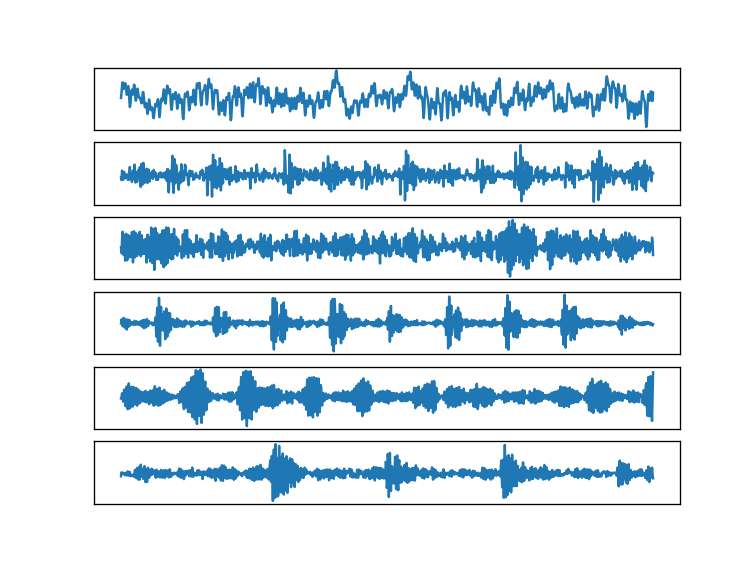

In [9]:
%matplotlib notebook

## define I
I = 0

## iterate y for 6 labels
for y in range(6):
    ## idx_labeled_y : train indices who have label y
    idx_labeled_y = train_idx[trainY==y]
    
    ## let's plot on y'th subplot
    ax = plt.subplot(6,1,y+1)
    
    ## remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    ## plot I'th frame of idx_labeled_y
    ax.plot(DATA[idx_labeled_y[I]:idx_labeled_y[I]+FRAME_LEN])
plt.show()

*Label y를 가진 I번째 데이터 확인*

- label = 0, diameters = [0]
- label = 1/2, diameters = [1,2,3,4]
- label = 3, diameters = [1,2,3]
- label = 4/5, diameters = [1,3]

<IPython.core.display.Javascript object>


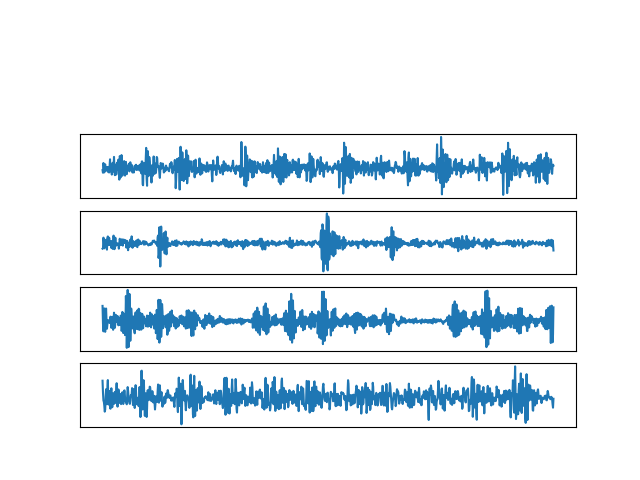

In [8]:
%matplotlib notebook

## define I and y
I=0
y=1

## iterate d for diameter range
for d in range(1,5):
    ## idx_diameter_d : train indices who have label y, diameter d
    idx_diameter_d = train_idx[(trainY==y)&(train_diameter==d)]
    
    ## let's plot on d'th subplot
    ax = plt.subplot(5,1,d+1)
    
    ## remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    ## plot I'th frame of idx_diameter_d
    ax.plot(DATA[idx_diameter_d[I]:idx_diameter_d[I]+FRAME_LEN])
plt.show()

*모든 (frame, label, fault diameter) 조합의 I번째 프레임 확인*

<IPython.core.display.Javascript object>


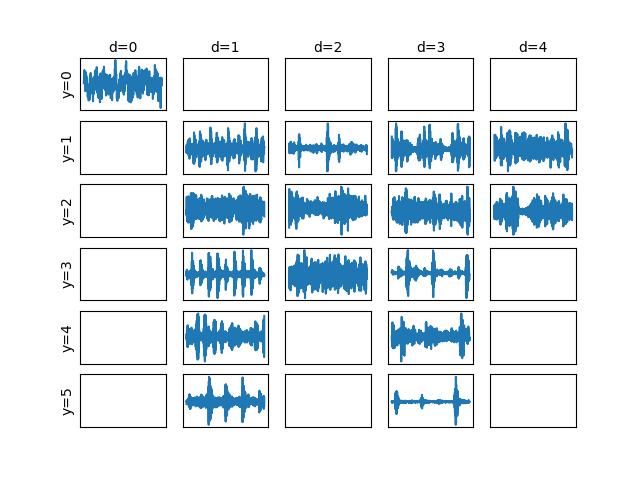

In [9]:
%matplotlib notebook

## define I
I = 0

## iterate y for all labels, d for all diameters
for y in range(6):
    for d in range(5):
        ## let's plot on (y,d)'th subplot
        ax = plt.subplot(6,5,5*y+d+1)
        
        ## write labels on axis
        if y==0:
            ax.set_xlabel('d=%d'%d)
            ax.xaxis.set_label_position('top')
        if d==0:
            ax.set_ylabel('y=%d'%y)
            
        ## remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ## idx_oi : train indices who have label y, diameter d
        idx_oi = train_idx[(trainY==y)&(train_diameter==d)]
        
        ## pass if there is no data for (y,d)
        if idx_oi.shape[0]==0:
            continue
        
        ## plot I'th data of idx_oi
        ax.plot(DATA[idx_oi[I]:idx_oi[I]+FRAME_LEN])
    
plt.show()

## 3. Supervised Learning!!!

- 모든 데이터가 Label이 주어졌을 때, Supervised Learning을 통해 학습할 수 있습니다.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [11]:
## fix seeds for reproducibility
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

## benchmark mode
torch.backends.cudnn.benchmark=True

### 3.1 Model Definition


<img src="resources/simplemodel.png" width="800">

In [12]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        ## encoder layers : Sequence of Convolution Blocks(Conv1d + ReLU + Dropout)
        self.enc_layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer3 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer4 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        
        ## classifier layers : Multi-Layer Perceptron(FC + ReLU)
        self.classifier1 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.classifier3 = nn.Linear(32, 6)
        
        ## initialize weights
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        '''
        initialize weights using Xavier initialization
        '''
        if type(m)==nn.Linear or type(m)==nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    def forward(self, x, get_latent=False):
        '''
        Input
            - x [torch.Tensor]: Batch of frames, size=(batch size, 1, frame length)
            - get_latent [bool]: whether return latent vector or not
        Output
            - [torch.Tensor] : prediction of the input batch, size=(batch size, # of labels)
            - (if get_latent) [torch.Tensor] : latent vector of the input batch, size=(batch size, latent dimension)
        '''
        
        ## encode (x -> z)
        x = self.enc_layer1(x)
        x = self.enc_layer2(x)
        x = self.enc_layer3(x)
        x = self.enc_layer4(x)
        x = x.mean(dim=-1)        ## aggregate final dimension
        z = x
        
        ## classify (z -> y)
        y = self.classifier1(z)        
        y = self.classifier2(y)     
        y = self.classifier3(y)
        
        if get_latent:
            return y,z
        else:
            return y
    

### 3.2 Train Configurations

In [13]:
## Train configurations
LR = 1e-3        ## learning rate
BATCH = 128      ## batch size
EPOCH = 500      ## # of epochs to run
TOL = 10         ## tolerance for early stopping
SAVE_PATH = './saved_models'  ## path to save model weights
SAV_INTV = 10                 ## save model on every SAV_INTV epochs

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


In [16]:
## generate our model
model = SimpleModel()

## and send it to GPU
model.cuda()

## ADAM optimizer to train model weights
optimizer = optim.Adam(model.parameters(), lr=LR)

In [17]:
## shuffle train indices
train_shuffle = np.arange(train_idx.shape[0])
np.random.shuffle(train_shuffle)

## split train data into two - train set, validation set
train_shuffle, val_shuffle = np.split(train_shuffle, [4*train_shuffle.shape[0]//5])
print(train_idx.shape, train_shuffle.shape, val_shuffle.shape)

(13966,) (11172,) (2794,)


### 3.3 Training Functions
Neural Network model의 parametr는 source directory 의 함수를 통해 학습됩니다

<img src="resources/epoch_batch.png" width="400">

Epoch 은 전체 Train data를 한번 사용하여 모델을 학습한 것이고, 사용자가 지정한 Epoch 수만큼 학습을 진행 합니다.

- epoch_step 에서는 각 epoch 마다 시행되는 batch_step 여러번 시행해줍니다. epoch step 에서는 batch step 한번마다 학습하기 위한 batch 를 정의해주고, batch step의 output을 통해 얻은 loss와 accuracy 의 평균값을 계산합니다.

- batch_step 에서는 각 batch 마다 loss와 Gradient를 계산하고, Back-propagation을 통해 loss를 줄여(model parameter를 업데이트) 나갑니다.



In [28]:
def batch_step(model, X, Y, M=None, train=False, optimizer=None, step=[0,0]):
    '''
    This function runs on every batch.
    You might want to run forward pass on the model (and backpropagate to update the weights if train==True).
    
    Input:
        - model [torch.nn.Module] : Your model
        - X [torch.Tensor] : Batch of frames. size=(batch size, 1, frame length)
        - Y [torch.Tensor] : True label of the input batch. Screened labels are set as 0. size=(batch size,)
        - M [torch.Tensor] : Mask. Each element is set True for labeled data and False for unlabeled data. size=(batch size,)
        - train [bool] : Whether it is training step or evaluation step
        - optimizer [torch.optim.Optimizer] : Optimizer
        - step [List[int,int]] : [Current epoch, Current batch]
    Output:
        - [torch.Tensor] : loss of current batch
        - [torch.Tensor] : predicted labels of current batch
    '''
    
    ## if M is not given, we define M set as all True
    if M is None:
        M = torch.zeros_like(Y) == 0
        M = M.to(device=X.device, dtype=torch.bool)
        
    ## forward pass
    ## p: output of forward pass
    p = model(X)
    
    ## pred : predicted labels
    pred = torch.argmax(p, dim=1)
    
    ## class_loss : classification loss.
    class_loss = torch.tensor(0.0).to(device=X.device)
    
    ## In supervised setting, we only train model if there are labeled data.
    if M.any():
        ## compute cross entropy loss of labeled data
        class_loss += nn.CrossEntropyLoss()(p[M],Y[M])

        ## if it is training step, backpropagate and update the model weights.
        if train:
            class_loss.backward()    ## backpropagation
            optimizer.step()         ## update model weights
            optimizer.zero_grad()    ## initialize gradients
    
    return class_loss, pred

In [29]:
def epoch_step(model, data_idx, dataY, data, train=False, shuffle=None, mask=None, optimizer=None, batch_step=batch_step, device=None,batch=128,frame_len=1024, e=0):
    '''
    This function runs on every epoch.
    You might want to run batches on the entire dataset.
    
    Input :
        - model [torch.nn.Module] : Your model
        - data_idx [numpy.array] : Indices for your dataset (ex. train_idx, test_idx)
        - dataY [numpy.array] : True labels for your dataset (ex. trainY, testY)
        - data [numpy.array] : Whole Dataset (ex. DATA)
        - etc.
    Output : 
        - Average Loss of current epoch
        - Average Accuracy of current epoch
    '''
    ## if shuffle is not given, generate shuffle with original order.
    if shuffle is None:
        shuffle = np.arange(data_idx.shape[0])
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    ## avg_loss : average loss
    ## n : number of processed data
    ## n_correct : number of correct data
    ## n_wrong : number of wrong data
    avg_loss = 0.0
    n = 0
    n_correct = 0
    n_wrong = 0
    
    ## run batches on the entire data
    for b in range((shuffle.shape[0]-1)//batch+1):
        ## X : input batch chosen from shuffled indices. (batch size, frame length, 1)
        ## Y : true labels of input batch. (batch size,)
        X = data[data_idx[shuffle[b*batch:(b+1)*batch]][:,None]+np.arange(frame_len)]
        Y = dataY[shuffle[b*batch:(b+1)*batch]]
        
        X = np.transpose(X, [0,2,1])    ## transpose X -> (batch size, 1, frame length)
        
        ## modify X, Y from numpy.array to torch.Tensor
        X = torch.tensor(X, device=device, dtype=torch.float)
        Y = torch.tensor(Y, device=device, dtype=torch.long)
        
        ## Yall : True labels
        Yall = Y.clone()
        if mask is None:
            M = None
        else:
            ## M : mask of input batch (for semisupervised learning)
            M = mask[shuffle[b*batch:(b+1)*batch]]
            M = torch.tensor(M, device=device, dtype=torch.bool)
            
            ## set labels of masked data to 0
            Y[~M]=0
            
        ## run batch_step
        ## loss : loss of the batch
        ## pred : predicted labels of the batch
        loss, pred = batch_step(model, X, Y, train=train, optimizer=optimizer, M=M, step=[e,b])
        
        ## correct/wrong : # of correct/wrong prediction of the batch
        correct = (Yall[Yall==pred]).shape[0]
        wrong = (Yall[Yall!=pred]).shape[0]
        
        ## update avg_loss, n, n_correct, n_wrong
        avg_loss = (avg_loss*n + loss.item()*X.shape[0])/(n+X.shape[0])
        n += X.shape[0]
        n_correct += correct
        n_wrong += wrong
    
    return avg_loss, n_correct/(n_correct+n_wrong)

def train(model, optimizer, train_idx, trainY, data, model_name, train_shuffle, val_shuffle, mask=None, batch_step=batch_step, sav_intv=10, tol=10, sav_path = './', device=None, epoch=500, batch=128,frame_len=1024):
    '''
    Train model with data
    
    Input:
        - model [torch.nn.Module] : Your model
        - optimizer [torch.optim.Optimizer] : Your optimizer
        - train_idx [numpy.array] : Indices of train set
        - trainY [numpy.array] : True labels of train set
        - data [numpy.array] : Entire train dataset
        - model_name [str] : Your model name
        - train_shuffle [numpy.array] : Shuffled indices for train set
        - val_shuffle [numpy.array] : Shuffled indices for validation set
        - mask [numpy.array] : Mask for semisupervised learning
        - etc.
    '''
    
    best_acc = 0
    
    ## Iterate for maximum 'epoch' times.
    for e in range(epoch):
        timestamp = time.time()
        
        ## set training mode on the model
        model.train()
        
        ## run epoch_step
        ## train_loss : average training loss of e-th epoch
        ## train_acc : average training accuracy of e-th epoch
        train_loss, train_acc = epoch_step(model, train_idx, trainY, data, train=True, optimizer=optimizer, shuffle=train_shuffle, mask=mask, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step, e=e)
        
        ## set evaluation mode on the model
        model.eval()
        
        with torch.no_grad():    ## with torch.no_grad(), we do not compute gradients -> faster!
            ## run epoch_step
            ## eval_loss : average validation loss of e-th epoch
            ## eval_acc : average validation accuracy of e-th epoch
            eval_loss, eval_acc = epoch_step(model, train_idx, trainY, data, train=False, shuffle=val_shuffle, mask=mask, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step, e=e)
        
        print('(%.2fs)[Epoch %d]'%(time.time()-timestamp, e+1))
        print('\t(train) loss : %.5f,\tacc : %.5f'%(train_loss, train_acc))
        print('\t(eval) loss : %.5f,\tacc : %.5f'%(eval_loss, eval_acc))
        
        ## if current epoch result best validation accuracy, we save current weight
        if eval_acc > best_acc:
            best_acc = eval_acc    ## update best_acc
            patience = 0           ## reset patience(used for early stopping)
            torch.save(model.state_dict(), '%s/%s_best.pth'%(sav_path, model_name))    ## save current model weights
        
        ## or save model weight for every 'sav_intv' epochs
        if e%sav_intv == sav_intv-1:
            torch.save(model.state_dict(), '%s/%s_e%d.pth'%(sav_path, model_name, e+1))
            
        ## increase patience(used for early stopping)
        patience += 1
        
        ## if validation accuracy has not increase for 'tol' epochs, early stop training
        if patience > tol:
            print('Early stop at Epoch %d'%(e+1))
            break

### 3.4 Start Training

In [15]:
TRAIN_PARAMS = {
    'model' : model,  ## Your model
    'optimizer' : optimizer,
    'train_idx' : train_idx,
    'trainY' : trainY,
    'data' : DATA,
    'model_name' : 'tutorial_supervised',
    'train_shuffle' : train_shuffle,
    'val_shuffle' : val_shuffle,
    'mask' : None,  ## None for supervised learning
    'sav_intv' : SAV_INTV,
    'tol' : TOL,
    'sav_path' : SAVE_PATH,
    'epoch' : EPOCH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step  ## Your batch_step function
}

In [22]:
train(**TRAIN_PARAMS)

(5.61s)[Epoch 1]
	(train) loss : 1.63021,	acc : 0.29860
	(eval) loss : 1.46837,	acc : 0.34538


KeyboardInterrupt: 

### 3.5 Testing

In [16]:
def test(model, test_idx, testY, data, model_name, batch_step=batch_step, load_version='best', sav_path = './', device=None, batch=128,frame_len=1024):
    '''
    Test your model with test set.
    
    Input :
        - model [torch.nn.Module] : Your model
        - test_idx [numpy.array] : Indices of the test set (ex. test_idx)
        - testY [numpy.array] : True labels of the test set (ex. testY)
        - data [numpy.array] : Entire dataset (ex. DATA)
        - model_name [str] : model name
        - batch_step [function] : Your batch_step function
        - load_version [str] : version of weights to load (ex. 'best', 'e10', 'e20', ...)
        - etc.
    '''
    timestamp = time.time()
    
    ## load saved model
    model.load_state_dict(torch.load('%s/%s_%s.pth'%(sav_path, model_name, load_version)))
    
    ## evaluation mode
    model.eval()
    
    with torch.no_grad():  ## do not compute gradients -> fast!
        ## run epoch_step
        ## loss : Average loss of the test set
        ## acc : Average accuracy of the test set
        loss, acc = epoch_step(model, test_idx, testY, data, train=False, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step)

    print('Test Result of model <%s>:%s'%(model_name, load_version))
    print('  [Loss]\t%.5f'%(loss))
    print('  [Accuracy]\t%.2f%%'%(acc*100))
    

In [17]:
TEST_PARAMS = {
    'model' : model,  ## Your model
    'test_idx' : test_idx,
    'testY' : testY,
    'data' : DATA,
    'model_name' : 'tutorial_supervised',  ## Your model name
    'load_version' : 'best',
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step  ## Your batch_step function
}

In [18]:
test(**TEST_PARAMS)

TypeError: batch_step() missing 1 required positional argument: 'Y'

In [19]:
from src.experiment import score_table
score_table(diameter = test_diameter, **TEST_PARAMS)



		0	1	2	3	4	5	| total
0"	|	1.0	-	-	-	-	-	| 1.0
0.007"	|	-	0.329	0.192	0.0	0.0	0.0	| 0.104
0.14"	|	-	0.843	0.125	0.0	-	-	| 0.322
0.021"	|	-	0.098	0.052	0.265	0.0	0.0	| 0.083
0.028"	|	-	0.005	1.0	-	-	-	| 0.5
------------------------------------------------------------------------
total	|	1.0	0.319	0.339	0.088	0.0	0.0	| 0.344


<IPython.core.display.Javascript object>


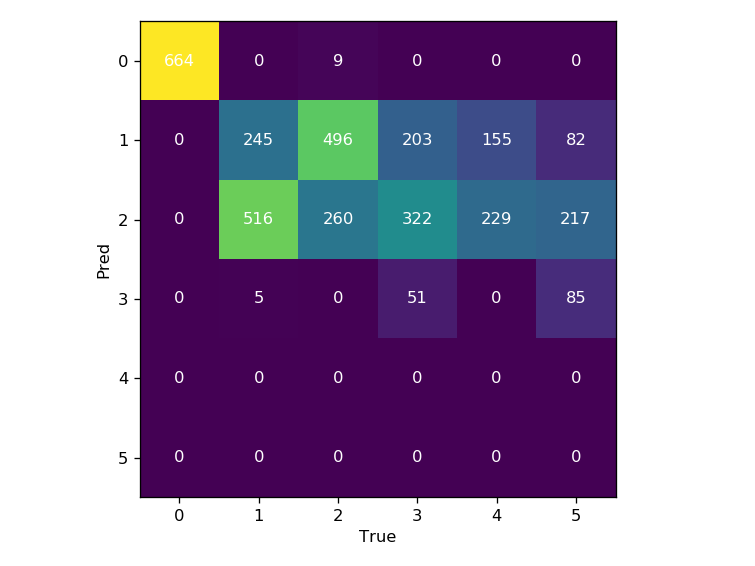

In [20]:
from src.experiment import confusion_matrix
%matplotlib notebook

confusion_matrix(**TEST_PARAMS)

### 3.6 Latent Vector Analysis

- Latent Vector Analysis에서는 Encoder의 output들이 어떻게 분포하는지를 분석합니다. Encoder의 output인 Latent Vector는 고차원이므로, t-SNE 와 같은 저차원을 Visualization 을 통해 분석해볼 수 있습니다. 

- Latent vector들이 각각 Label, Prediction, Diameter, RPM에 따라 어떻게 분포하는지 mapping 하고, Model이 형성하고 있는 Latent space 가 데이터셋을 잘 표현하고 있는 representation인지 분석합니
다.

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from src.experiment import get_latents

In [27]:
## get latent vectors and prediction
## z : latent vectors
## preds : predictions
z, preds = get_latents(**TEST_PARAMS)

## convert z/preds from torch.Tensor to numpy.array
z = z.cpu().numpy()
preds = preds.cpu().numpy()

print(z.shape, preds.shape)

(3539, 32) (3539,)


In [30]:
## reduce feature dimension to 2 with tSNE (for visualization)
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z)
print(z_tsne.shape)

(3539, 2)


In [31]:
def draw_plot(tsne, label, cmap = None, legend = False, ax=None):
    '''
    Plot 'tsne', colored according to 'label'
    
    Input :
        - tsne [numpy.array] : tsne result. size=(# of points, 2)
        - label [numpy.array] : labels to decide color of each points. size=(# of points,)
        - cmap : matplotlib colormap
        - legend [bool] : whether to show legend or not
        - ax : matplotlib axis to plot on
    '''
    if ax is None:
        ax = plt.subplot(1,1,1)
        
    if cmap is None:
        cmap = plt.cm.get_cmap('coolwarm')
    
    ## remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    ## scatter tsne
    if not legend:
        ax.scatter(tsne[:,0], tsne[:,1], s=1, cmap=cmap, c=label, picker=5)
    else:
        set_l = set(label)
        for i, l in enumerate(set_l):
            ax.scatter(tsne[:,0][label==l], tsne[:,1][label==l], c=cmap(i/len(set_l)), cmap=cmap, label=l, s=1, picker=5)
            ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


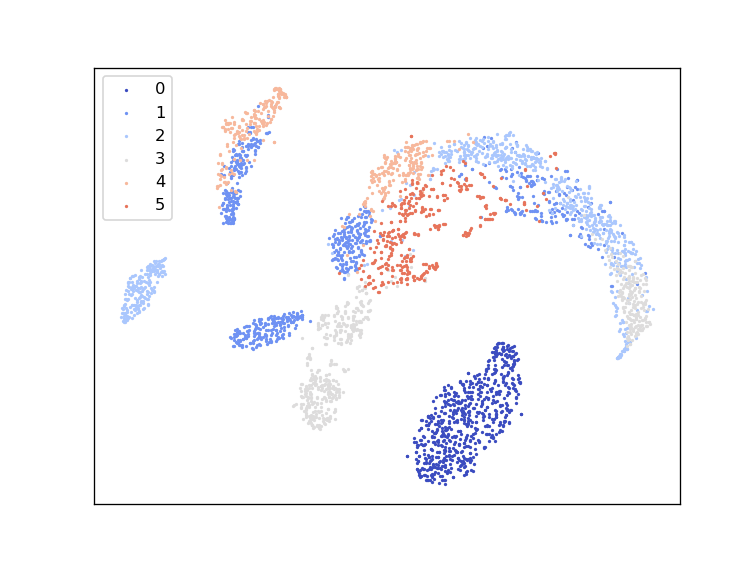

In [34]:
%matplotlib notebook
## color with true label
draw_plot(z_tsne, label=testY, legend=True)

<IPython.core.display.Javascript object>


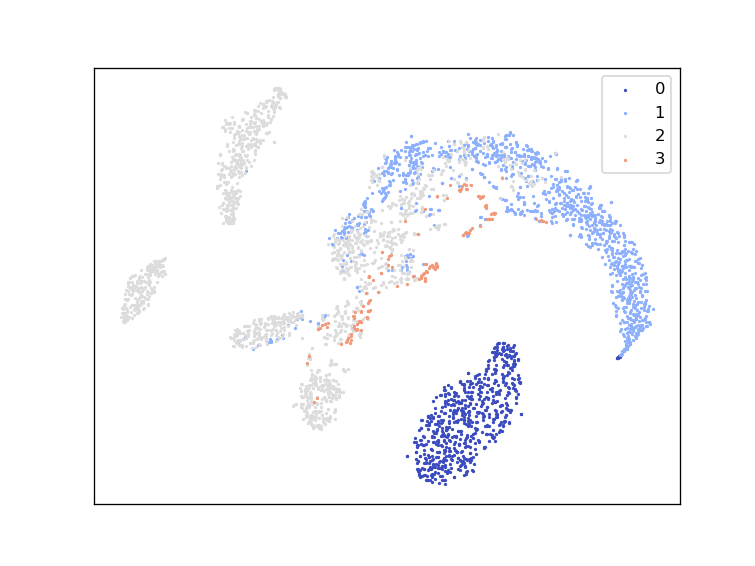

In [35]:
%matplotlib notebook
## color with predicted label
draw_plot(z_tsne, label=preds, legend=True)

<IPython.core.display.Javascript object>


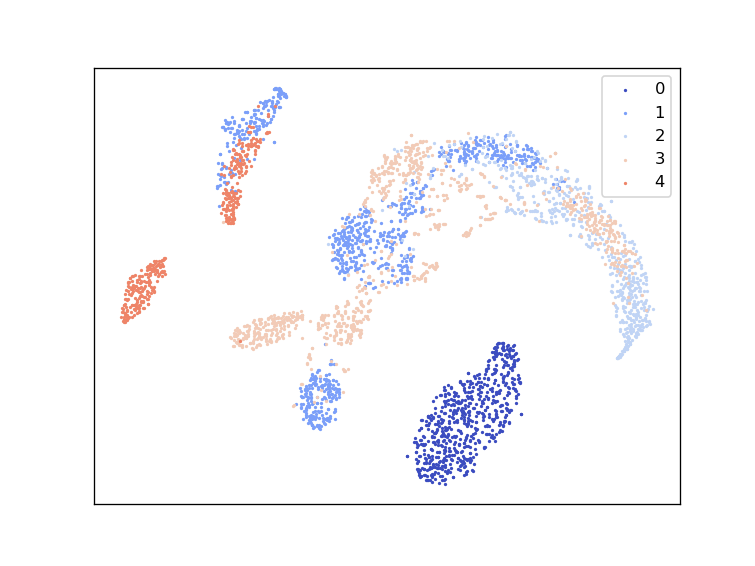

In [36]:
%matplotlib notebook
## color with fault diameters
draw_plot(z_tsne, label=test_diameter, legend=True)

<IPython.core.display.Javascript object>


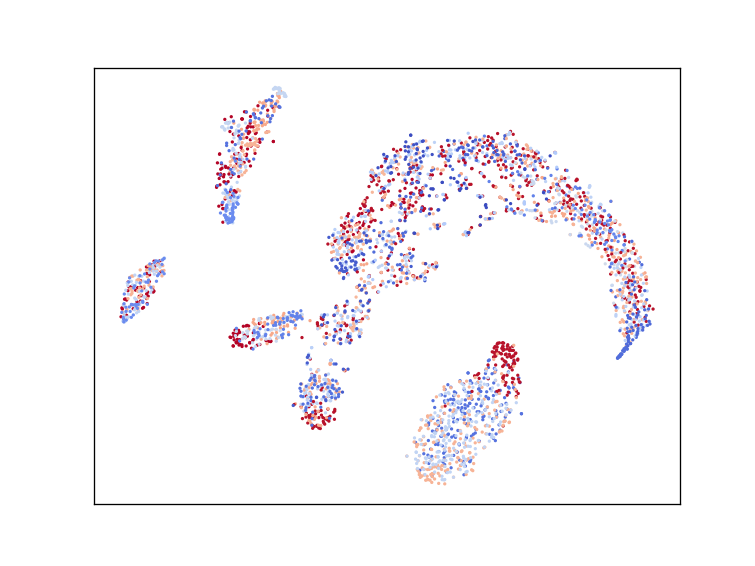

In [37]:
%matplotlib notebook
## color with RPMs
draw_plot(z_tsne, label=test_rpm)

In [12]:
def draw_magic(tsne, label, raw, index, cmap = None, frame_len=1024, frame_intv=512):
    global p, m,pick
    p=None
    fig=plt.figure(figsize=(8,8))
    ax0 = plt.subplot2grid((4,1),(0,0),rowspan=3)#(3,1,1)
    ax1 = plt.subplot(414)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    m=0
    pick=False
    text = ax0.text(0,100,"Label %d"%m,va='top',ha='left')
    def onpress(event):
        global m,pick
        if event.key=='right' and m < len(label)-1:
            m+=1
        elif event.key == 'left' and m > 0:
            m-=1
        else:
            return
        if pick:
            p.remove()
            pick=False
        ax0.cla()
        ax0.set_xticks([])
        ax0.set_yticks([])
        text = ax0.text(0,100,"Label %d"%m,va='top',ha='left')
        draw_plot(tsne, label[m], cmap, legend=False, ax=ax0)
        fig.canvas.draw()
        
    def onpick(event):
        global p,pick
        pt = event.ind[0]
        if pick:
            p.remove()
            pick=False
        p = ax0.scatter(tsne[pt,0],tsne[pt,1],marker='x',s=10,c='k')
        pick=True
        
        ax1.cla()
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.plot(raw[index[pt]:index[pt]+frame_len][:,0])
        fig.canvas.draw()
        
    cid = fig.canvas.mpl_connect('pick_event', onpick)
    cid2 = fig.canvas.mpl_connect('key_press_event', onpress)
    draw_plot(tsne, label[m], cmap, legend=False, ax=ax0)
    plt.show()

In [13]:
%matplotlib notebook
draw_magic(z_tsne, [preds, testY, test_diameter, test_rpm], DATA, test_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV)

NameError: name 'z_tsne' is not defined

## 4. Semisupervised Learning!!!!

### 4.1 Mask Definition
<img src="resources/masking.png" width="400">


- Session4, Semi-supervised Learning에서는 앞서 사용한 Data 중에서 일부분만 Label을 가지고 있다고 가정합니다.

- DATA 중에서 0.5% 의 DATA만 Label을 유지하고, 나머지는 masking 합니다.(즉, label을 가립니다)


In [1]:
MASK_P = 0.005        ## Only (100*MASK_P)% of train data are labeled

In [2]:
from src.utils.data_utils import show_table
SEED=0
np.random.seed(SEED)
while True:
    MASK = np.array([False]*trainY.shape[0])
    MASK = np.random.choice(MASK.shape[0], MASK.shape[0], replace=False) < int(MASK_P*trainY.shape[0])
    if set([0,1,2,3,4,5]).issubset(set(trainY[MASK])):
        print('SEED : %d'%SEED)
        break
    SEED+=1
    np.random.seed(SEED)
print("# of labeled data : %d"%MASK.sum())
print('# of unlabeled data : %d'%(MASK.shape[0]-MASK.sum()))
print('percentage : %.2f%%'%(100*MASK.sum()/MASK.shape[0]))

show_table(MASK, trainY, train_diameter, average=False)

NameError: name 'np' is not defined

### 4.2 Training
라벨이 주어진 데이터만 가지고 naive하게 supervised learning을 진행합니다.

In [41]:
## generate our model
model = SimpleModel()

## and send it to GPU
model.cuda()

## ADAM optimizer to train model weights
optimizer = optim.Adam(model.parameters(), lr=LR)

In [42]:
## shuffle train indices
train_shuffle = np.arange(train_idx.shape[0])
np.random.shuffle(train_shuffle)

## split train data into two - train set, validation set
train_shuffle, val_shuffle = np.split(train_shuffle, [4*train_shuffle.shape[0]//5])
print(train_idx.shape, train_shuffle.shape, val_shuffle.shape)

(13966,) (11172,) (2794,)


In [43]:
TRAIN_PARAMS = {
    'model' : model,  ## Your model
    'optimizer' : optimizer,
    'train_idx' : train_idx,
    'trainY' : trainY,
    'data' : DATA,
    'model_name' : 'tutorial_semi', ## Your model name
    'train_shuffle' : train_shuffle,
    'val_shuffle' : val_shuffle,
    'mask' : MASK,  ## Your MASK
    'sav_intv' : SAV_INTV,
    'tol' : TOL,
    'sav_path' : SAVE_PATH,
    'epoch' : EPOCH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step  ## Your batch_step function
}

In [44]:
train(**TRAIN_PARAMS)

(2.07s)[Epoch 1]
	(train) loss : 0.92317,	acc : 0.21527
	(eval) loss : 0.99577,	acc : 0.20830
(2.02s)[Epoch 2]
	(train) loss : 0.88511,	acc : 0.22494
	(eval) loss : 1.02238,	acc : 0.21618
(1.92s)[Epoch 3]
	(train) loss : 0.86973,	acc : 0.31489
	(eval) loss : 1.01709,	acc : 0.26986
(1.85s)[Epoch 4]
	(train) loss : 0.85056,	acc : 0.36207
	(eval) loss : 1.00170,	acc : 0.41124
(1.84s)[Epoch 5]
	(train) loss : 0.81703,	acc : 0.40637
	(eval) loss : 0.97902,	acc : 0.42555
(1.86s)[Epoch 6]
	(train) loss : 0.78379,	acc : 0.43806
	(eval) loss : 0.96876,	acc : 0.41195
(1.88s)[Epoch 7]
	(train) loss : 0.80293,	acc : 0.40029
	(eval) loss : 0.94198,	acc : 0.40623
(1.83s)[Epoch 8]
	(train) loss : 0.72534,	acc : 0.42213
	(eval) loss : 0.91383,	acc : 0.46421
(1.92s)[Epoch 9]
	(train) loss : 0.66273,	acc : 0.41667
	(eval) loss : 0.89104,	acc : 0.45777
(2.06s)[Epoch 10]
	(train) loss : 0.64829,	acc : 0.39608
	(eval) loss : 0.86727,	acc : 0.42770
(1.86s)[Epoch 11]
	(train) loss : 0.56490,	acc : 0.40485
	(

### 4.3 Testing

In [45]:
TEST_PARAMS = {
    'model' : model,  ## Your model
    'test_idx' : test_idx,
    'testY' : testY,
    'data' : DATA,
    'model_name' : 'tutorial_semi',  ## Your model name
    'load_version' : 'best',  ## version of model weights to load
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step  ## Your batch_step function
}

In [46]:
test(**TEST_PARAMS)

Test Result of model <tutorial_semi>:best
  [Loss]	2.57499
  [Accuracy]	56.51%


In [38]:
score_table(diameter = test_diameter, **TEST_PARAMS)



		0	1	2	3	4	5	| total
0"	|	1.0	-	-	-	-	-	| 1.0
0.007"	|	-	0.732	1.0	0.911	0.989	0.822	| 0.891
0.14"	|	-	0.0	0.505	0.0	-	-	| 0.168
0.021"	|	-	0.208	0.942	0.687	0.869	0.687	| 0.679
0.028"	|	-	1.0	0.931	-	-	-	| 0.965
------------------------------------------------------------------------
total	|	1.0	0.484	0.844	0.532	0.929	0.755	| 0.744


<IPython.core.display.Javascript object>


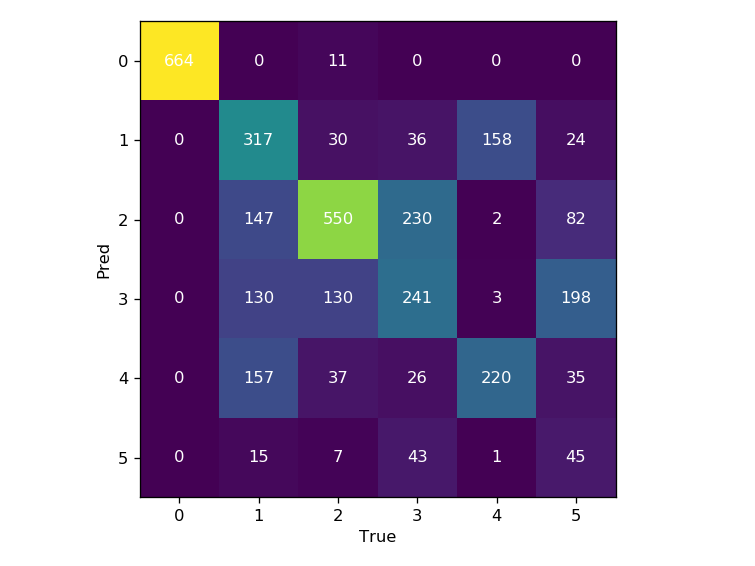

In [44]:
%matplotlib notebook
confusion_matrix(**TEST_PARAMS)

- Confusion matrix 를 통해 model이 어떤 부분을 정확하게 Classify하고, 어떤 부분에서 문제를 갖는지 분석합니다.

- Confusion matrix 의 대각성분이 작다는 것은 정확도가 낮다는 것입니다.

In [49]:
## get latent vectors and prediction
## z : latent vectors
## preds : predictions
z, preds = get_latents(**TEST_PARAMS)

## convert z/preds from torch.Tensor to numpy.array
z = z.cpu().numpy()
preds = preds.cpu().numpy()

print(z.shape, preds.shape)

(3539, 32) (3539,)


In [50]:
## reduce feature dimension to 2 with tSNE (for visualization)
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z)
print(z_tsne.shape)

(3539, 2)


<IPython.core.display.Javascript object>


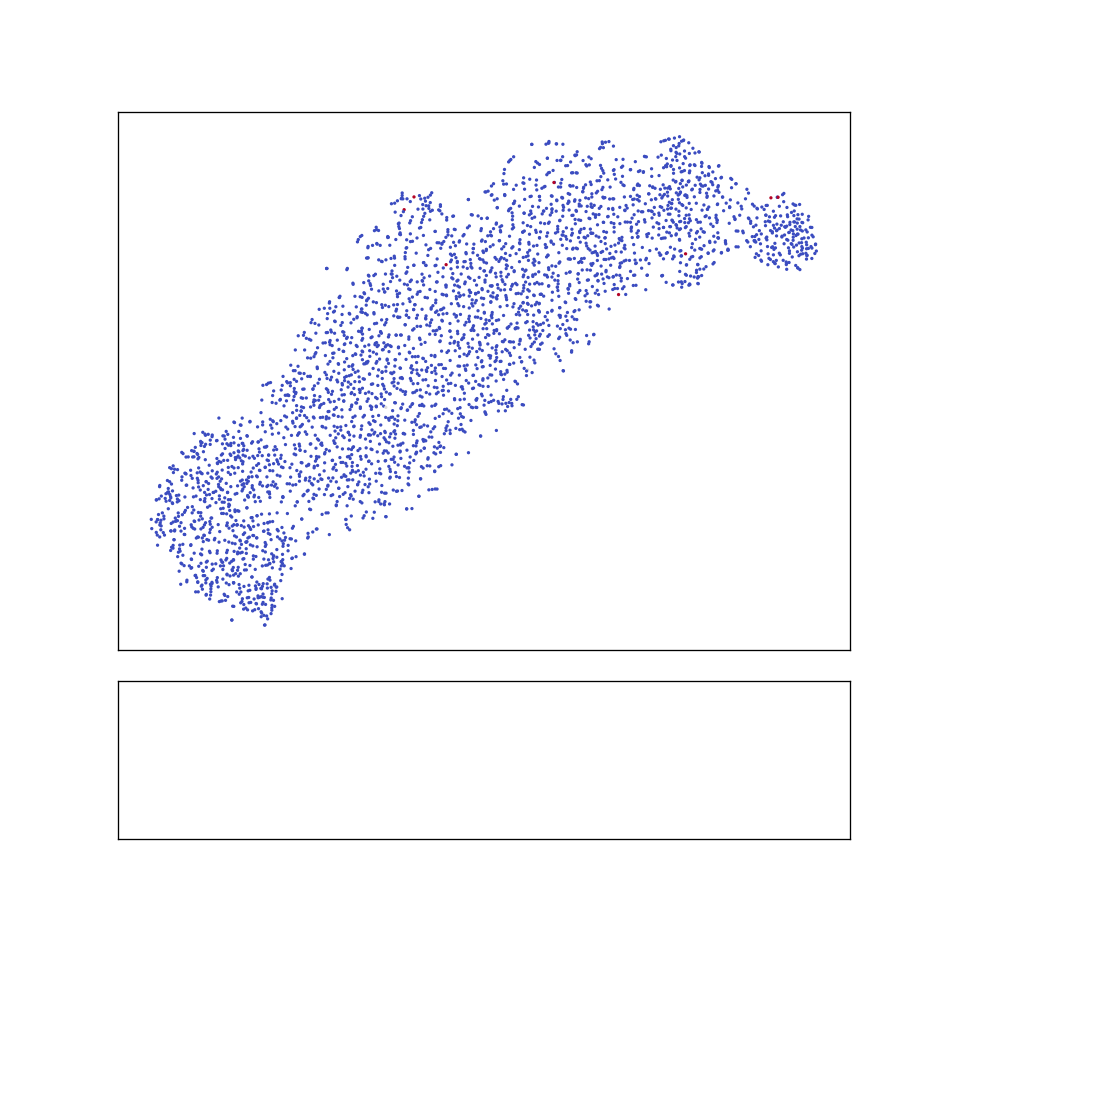

In [51]:
%matplotlib notebook
draw_magic(z_tsne, [preds, testY, test_diameter, test_rpm], DATA, test_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV)

In [52]:
TEST_PARAMS = {
    'model' : model,  ## Your model
    'data' : DATA,
    'model_name' : 'tutorial_semi',  ## Your model name
    'load_version' : 'best',  ## version of model weights to load
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step  ## Your batch_step function
}

\[ EVALUATE TRAIN DATA \]

In [14]:
test(**TEST_PARAMS, test_idx = train_idx, testY = trainY)

NameError: name 'test' is not defined

\[ EVALUATE LABELED DATA \]

In [54]:
test(**TEST_PARAMS, test_idx=train_idx[MASK], testY=trainY[MASK])

Test Result of model <tutorial_semi>:best
  [Loss]	1.77680
  [Accuracy]	18.84%


\[ EVALUATE UNLABELED DATA \]

In [55]:
test(**TEST_PARAMS, test_idx=train_idx[~MASK], testY=trainY[~MASK])

Test Result of model <tutorial_semi>:best
  [Loss]	1.77646
  [Accuracy]	21.64%


In [56]:
z_train, preds_train = get_latents(**TEST_PARAMS, test_idx=train_idx, testY=trainY)
z_train = z_train.cpu().numpy()
preds_train = preds_train.cpu().numpy()

In [57]:
tsne = TSNE(n_components=2)
z_tsne_train = tsne.fit_transform(z_train)
print(z_tsne_train.shape)

(13966, 2)


<IPython.core.display.Javascript object>


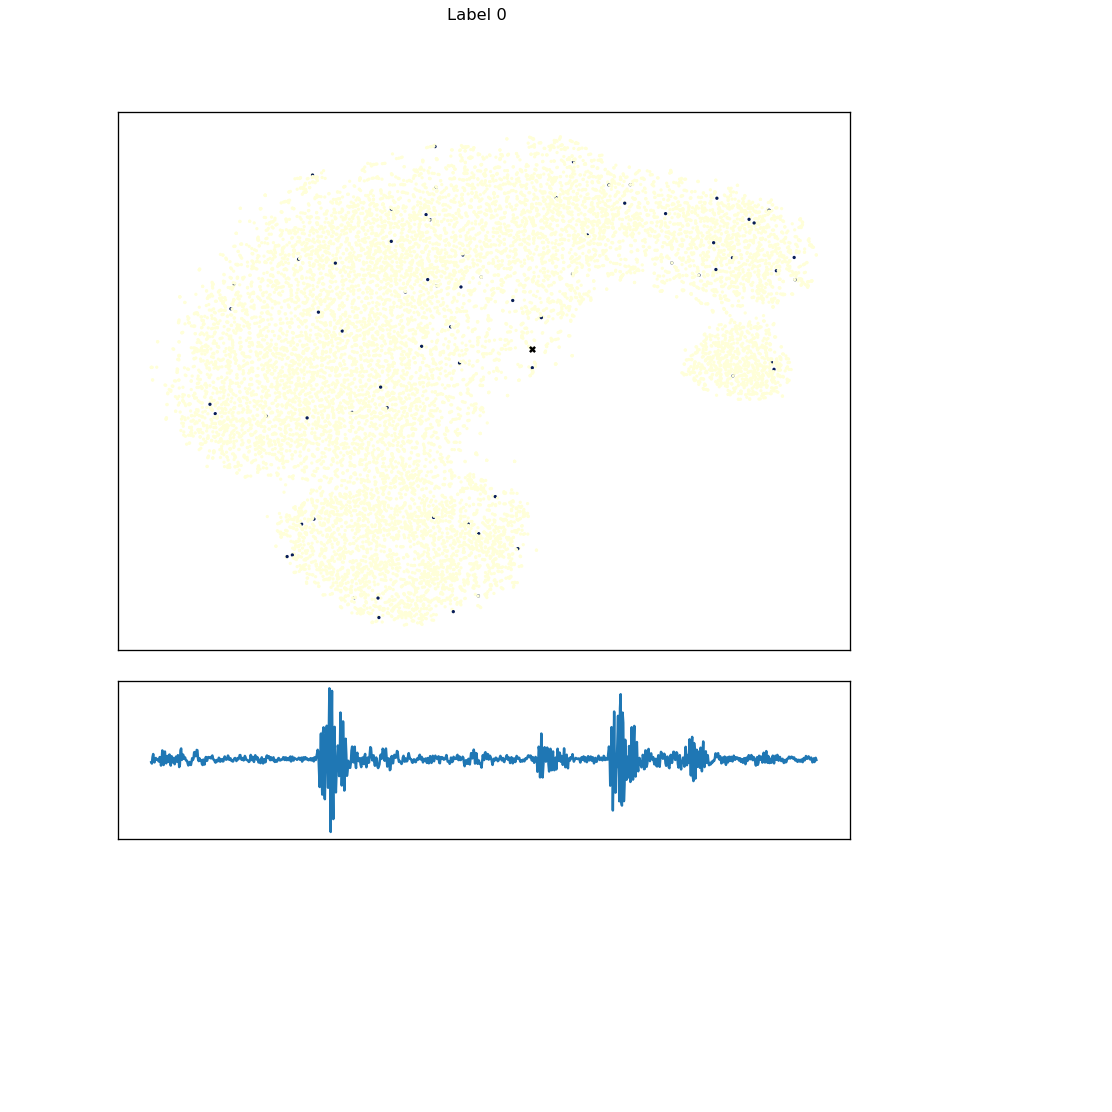

In [58]:
%matplotlib notebook
draw_magic(z_tsne_train, [MASK,preds_train, trainY, train_diameter, train_rpm], DATA, train_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV, cmap='YlGnBu')

***<Project.ipynb>에서 여러분만의 모델을 실험해보세요!***